In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d

In [3]:
rec_x = np.arange(61)*100
rec_y = np.array([-500, 0, 500, 1000, 1500, 2000, 2500])
rec_z = 0.0
rec = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.RxElectricPoint,
        (np.tile(rec_x, rec_y.size), rec_y.repeat(rec_x.size), rec_z, 0, 0)
)

src_x = np.array([0, 3000, 6000])
src_y = np.array([0, 1000, 2000])
src_z = 50.0
src = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.TxElectricDipole,
        (np.tile(src_x, src_y.size), src_y.repeat(src_x.size), src_z, 0, 0)
)

frequencies = np.array([0.1, 0.3, 1.0, 3.2])

survey = emg3d.surveys.Survey(
    sources=src,
    receivers=rec,
    frequencies=frequencies,
    noise_floor=1e-17,
    relative_error=0.05,
)
survey

:: Survey ::

<xarray.Dataset> Size: 260kB
Dimensions:   (src: 9, rec: 427, freq: 4)
Coordinates:
  * src       (src) <U6 216B 'TxED-1' 'TxED-2' 'TxED-3' ... 'TxED-8' 'TxED-9'
  * rec       (rec) <U8 14kB 'RxEP-001' 'RxEP-002' ... 'RxEP-426' 'RxEP-427'
  * freq      (freq) <U3 48B 'f-1' 'f-2' 'f-3' 'f-4'
Data variables:
    observed  (src, rec, freq) complex128 246kB (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-17
    relative_error:  0.05

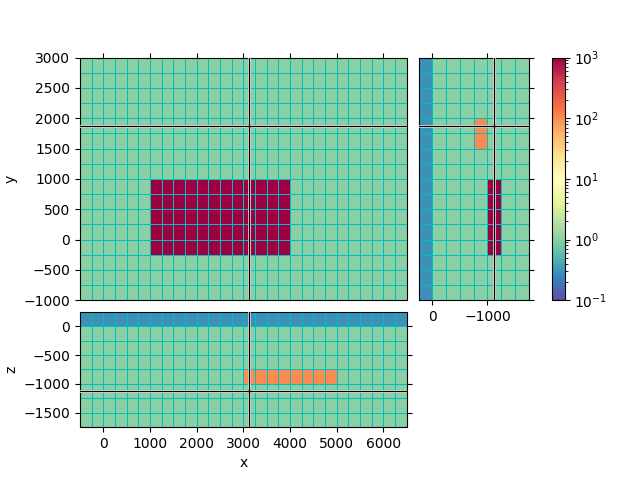

In [4]:
hx = np.ones(28)*250.0
hy = np.ones(16)*250.0
hz = np.ones(8)*250
grid = emg3d.TensorMesh([hx, hy, hz], [-500, -1000, -1750])

model_start = emg3d.Model(grid, 1.0, mapping='Conductivity')
model_true = emg3d.Model(grid, 1.0, mapping='Conductivity')
# Target
model_true.property_x[6:18, 3:8, 2:3] = 0.001
model_true.property_x[14:22, 10:12, 3:4] = 0.01
# Water
model_start.property_x[:, :, -1] = 3.3
model_true.property_x[:, :, -1] = 3.3

grid.plot_3d_slicer(
    1/model_true.property_x, yslice=2000, zslice=-1000,
    pcolor_opts={'cmap': 'Spectral_r', 'norm': LogNorm(vmin=.1, vmax=1000), 'lw': 0.5, 'color': 'c'}
)

# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')

In [5]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=survey,
    model=model_true,
    gridding='both',
    max_workers=40,
    receiver_interpolation='linear',
    solver_opts={'tol_gradient': 1e-2},
    gridding_opts={'vector': 'xyz'},
)
sim

:: Simulation ::

- Survey: 9 sources; 427 receivers; 4 frequencies
- Model: conductivity; isotropic; 28 x 16 x 8 (3,584)
- Gridding: Frequency- and source-dependent grids; 40 x 24 x 16 (15,360) - 48 x 32 x 24 (36,864)

In [6]:
sim.compute(observed=True, min_offset=400)
sim.clean('computed')

sim.model = model_start

sim.tqdm_opts = False

sim.compute()
sim.survey.data['start'] = sim.survey.data.synthetic
sim.clean('computed')

sim._tqdm_opts = {'disable': True}

emg3d.save(f'bigtest.h5', simulation=sim, survey=survey, model_true=model_true)

Compute efields            0/36  [00:00]

Compute efields            0/36  [00:00]

In [ ]:
emg3d.Report()